In [56]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from math import log10
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('autos.csv',sep=',',header = 0,encoding ='cp1252')

In [3]:
data.sample(2)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
227107,2016-03-09 18:55:26,Mondeo_2.0__mit_Tuev,privat,Angebot,1200,test,NaN,2017,manuell,116,mondeo,150000,1,NaN,ford,nein,2016-03-09 00:00:00,0,79822,2016-04-07 14:57:32
24979,2016-04-03 19:38:55,BMW_Z4_Cabrio_Bj._2005_2._Hand._Garage_Super_o...,privat,Angebot,9400,test,cabrio,2005,manuell,150,z_reihe,150000,6,benzin,bmw,nein,2016-04-03 00:00:00,0,90411,2016-04-03 19:38:55


In [ ]:
#data.describe()

In [4]:
#data pre-processing : throw useless columns
data.drop(['dateCrawled','seller','offerType','abtest','notRepairedDamage','nrOfPictures','lastSeen','postalCode','dateCreated','model','monthOfRegistration'],axis = 'columns',inplace = True)

In [5]:
data.sample(2)

,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,fuelType,brand
132366,Peugeot_206_HDI_Quiksilver_mit_Webasto_Standhe...,1200,NaN,2005,manuell,110,150000,NaN,peugeot
146127,Ford_Focus_Fun,4100,kombi,2007,manuell,101,90000,benzin,ford


In [6]:
# throw extreme examples
print("Too new: %d" % data.loc[data.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % data.loc[data.yearOfRegistration < 1980].count()['name'])
print("Too cheap: %d" % data.loc[data.price < 100].count()['name'])
print("Too expensive: " , data.loc[data.price > 150000].count()['name'])
print("Too few km: " , data.loc[data.kilometer < 5000].count()['name'])
print("Too many km: " , data.loc[data.kilometer > 200000].count()['name'])
print("Too few PS: " , data.loc[data.powerPS < 10].count()['name'])
print("Too many PS: " , data.loc[data.powerPS > 500].count()['name'])
print("Vehicle types: " , data['vehicleType'].unique())
print('brand types:',data['brand'].unique())
print('fuelType:',data['fuelType'].unique())


Too new: 14680
Too old: 4119
Too cheap: 13320
Too expensive:  232
Too few km:  0
Too many km:  0
Too few PS:  41040
Too many PS:  835
Vehicle types:  [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
brand types: ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda' 'nissan'
 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat' 'mini'
 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'porsche' 'toyota' 'chevrolet'
 'dacia' 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'rover'
 'land_rover' 'lada']
fuelType: ['benzin' 'diesel' nan 'lpg' 'andere' 'hybrid' 'cng' 'elektro']


In [8]:
#drop duplicate 
dedups = data.drop_duplicates(['name','price','vehicleType','yearOfRegistration','gearbox','powerPS','kilometer','brand','fuelType'])

In [9]:
dedups = dedups[(dedups.yearOfRegistration <= 2016) 
      & (dedups.yearOfRegistration >= 1980) 
      & (dedups.price >= 1000) 
      & (dedups.price <= 150000) 
      & (dedups.powerPS >= 50)     # 
      & (dedups.powerPS <= 350)]   #

In [10]:
print("-----------------\n After drop duplica and extrem example, Data kept for analisys: %d percent of the entire set\n-----------------" % (100 * dedups['name'].count() / data['name'].count()))

-----------------
 After drop duplica and extrem example, Data kept for analisys: 65 percent of the entire set
-----------------


In [11]:
dedups.isnull().sum()

name                     0
price                    0
vehicleType           5912
yearOfRegistration       0
gearbox               3264
powerPS                  0
kilometer                0
fuelType              9258
brand                    0
dtype: int64

In [12]:
dedups_nonull = dedups.dropna()  

In [13]:
print("-----------------\nAfter dropping all Null,Data kept for analisys: %d percent of the entire set\n-----------------" % (100 * dedups_nonull['name'].count() / data['name'].count()))

-----------------
After dropping all Null,Data kept for analisys: 61 percent of the entire set
-----------------


In [14]:
wholedata = dedups_nonull


In [15]:
print("Vehicle types: " , wholedata['vehicleType'].unique())
print('brand types:',wholedata['brand'].unique())
print("gear box: " , wholedata['gearbox'].unique())
print('fuelType',wholedata['fuelType'].unique())

Vehicle types:  ['coupe' 'suv' 'kleinwagen' 'cabrio' 'bus' 'limousine' 'kombi' 'andere']
brand types: ['audi' 'jeep' 'volkswagen' 'skoda' 'peugeot' 'ford' 'mazda' 'nissan'
 'renault' 'mercedes_benz' 'bmw' 'honda' 'mini' 'smart' 'subaru' 'volvo'
 'mitsubishi' 'opel' 'hyundai' 'alfa_romeo' 'kia' 'seat' 'lancia' 'porsche'
 'citroen' 'fiat' 'toyota' 'chevrolet' 'dacia' 'suzuki' 'daihatsu'
 'chrysler' 'sonstige_autos' 'jaguar' 'rover' 'saab' 'daewoo' 'land_rover'
 'lada' 'trabant']
gear box:  ['manuell' 'automatik']
fuelType ['diesel' 'benzin' 'lpg' 'andere' 'hybrid' 'cng' 'elektro']


In [16]:
gear_type = list(wholedata['gearbox'].unique())
vehicle_type = list(wholedata['vehicleType'].unique())
brand_type = list(wholedata['brand'].unique())
fuel_type = list(wholedata['fuelType'].unique())

In [17]:
gear_dict = dict(zip(gear_type,[x for x in range(1,len(gear_type)+1)]))
vehicle_dict = dict(zip(vehicle_type,[x for x in range(1,len(vehicle_type)+1)]))
brand_dict = dict(zip(brand_type,[x for x in range(1,len(brand_type)+1)]))
fuel_dict = dict(zip(fuel_type,[x for x in range(1,len(fuel_type)+1)]))

In [176]:
gear = list(wholedata.gearbox)
gear_list = [0]*len(gear)
for i in range(len(gear)):
    gear_list[i] = gear_dict[gear[i]]
vehicle = list(wholedata.vehicleType)
vehicle_list = [0]*len(vehicle)
for i in range(len(vehicle)):
    vehicle_list[i] = vehicle_dict[vehicle[i]]
brand = list(wholedata.brand)
brand_list = [0]*len(brand)
for i in range(len(brand)):
    brand_list[i] = brand_dict[brand[i]]
name = list(wholedata.name)
namelen_list = [0]*len(name)
for i in range(len(name)):
    namelen_list[i] = len(name[i])
fuel = list(wholedata.fuelType)
fuel_list = [0]*len(fuel)
for i in range(len(fuel)):
    fuel_list[i] = fuel_dict[fuel[i]]


In [181]:
#########################################
#########   linear regression   #########
#########################################
#create X_training and y_training for linear regression  
#namelen_list
#vehicle_list
year_list = list(wholedata.yearOfRegistration)
#gear_list
price_list = list(wholedata.price)
price_list = [log10(y) for y in price_list]
powerPS_list = list(wholedata.powerPS)
kilo_list = list(wholedata.kilometer)
#brand_list

X = []
for i in range(len(wholedata)):
    #datum = [1,namelen_list[i],vehicle_list[i],year_list[i],gear_list[i],powerPS_list[i],kilo_list[i],brand_list[i]]
    datum = [1,namelen_list[i],year_list[i],gear_list[i],powerPS_list[i],kilo_list[i],brand_list[i],fuel_list[i]]
    X.append(datum)
y = price_list
training_len = int(0.64*len(wholedata))    #training 50%
validation_len = int(0.8*len(wholedata))  # validation 30%  


In [182]:
X_training = X[:training_len]
y_training = y[:training_len]
X_validation = X[training_len:validation_len]
y_validation = y[training_len:validation_len]
X_test = X[validation_len:]
y_test = y[validation_len:]

In [183]:
clf = linear_model.Ridge(1, fit_intercept=False)
clf.fit(X_training, y_training)
theta = clf.coef_
predictions = clf.predict(X_training)
MSE = 0
for i in range(len(predictions)):
    MSE += (y_training[i]-predictions[i])**2
MSE = MSE/len(predictions)
print('MSE for training data using ridge regression is :',MSE)
validation_predictions = clf.predict(X_validation)
MSE = 0
for i in range(len(validation_predictions)):
    MSE += (y_validation[i]-validation_predictions[i])**2
MSE = MSE/len(validation_predictions)
print('MSE for validation data using ridge regression is :',MSE)
test_predictions = clf.predict(X_test)
MSE = 0
for i in range(len(test_predictions)):
    MSE += (y_test[i]-test_predictions[i])**2
MSE = MSE/len(test_predictions)
print('MSE for test data using ridge regression is :',MSE)
score = clf.score(X_validation,y_validation)
print('variance score for validation is :',score)
score_mse = -cross_val_score(clf, X_validation, y_validation, scoring='neg_mean_squared_error',cv=6) 
print('average of MSE score for validation:',sum(score_mse)/len(score_mse))
score = clf.score(X_test,y_test)
print('variance score for test is :',score)
score_mse = -cross_val_score(clf, X_test, y_test, scoring='neg_mean_squared_error',cv=6) 
print('average of MSE score for test:',sum(score_mse)/len(score_mse))

MSE for training data using ridge regression is : 23657203.5858
MSE for validation data using ridge regression is : 23556780.0444
MSE for test data using ridge regression is : 24195185.2399
variance score for validation is : 0.596280926973
average of MSE score for validation: 24438615.1898
variance score for test is : 0.581219998203
average of MSE score for test: 24908897.7867


In [185]:
predictions[:10]

array([ 13563.3233342 ,  11232.68603236,   -149.91144808,   7786.67610998,
         2526.89920011,  15373.52396204,   2160.5828344 ,   7050.07412782,
        17990.64467224,    653.87835869])

In [123]:
training_mse = []
training_score = []
validation_mse = []
validation_score = []
test_mse = []
test_score = []
alpha = np.arange(0, 10.0, 0.25)
def linear_training(alpha):
    clf = linear_model.Ridge(alpha, fit_intercept=False)
    clf.fit(X_training, y_training)
    theta = clf.coef_
    predictions = clf.predict(X_training)
    MSE = 0
    for i in range(len(predictions)):
        MSE += (y_training[i]-predictions[i])**2
    MSE = MSE/len(predictions)
    #print('MSE for training data using baseline is :',MSE)
    training_mse.append(MSE)
    score = clf.score(X_training,y_training)
    #print('variance score for training is :',score)
    training_score.append(score)
    return
def linear_validation(alpha):
    clf = linear_model.Ridge(alpha, fit_intercept=False)
    clf.fit(X_training, y_training)
    validation_predictions = clf.predict(X_validation)
    MSE = 0
    for i in range(len(validation_predictions)):
        MSE += (y_validation[i]-validation_predictions[i])**2
    MSE = MSE/len(validation_predictions)
    #print('MSE for validation data using baseline is :',MSE)
    validation_mse.append(MSE)
    score = clf.score(X_validation,y_validation)
    #print('variance score for validation is :',score)
    return
def linear_test(alpha):
    clf = linear_model.Ridge(alpha, fit_intercept=False)
    clf.fit(X_training, y_training)
    test_predictions = clf.predict(X_test)
    MSE = 0
    for i in range(len(test_predictions)):
        MSE += (y_test[i]-test_predictions[i])**2
    MSE = MSE/len(test_predictions)
    #print('MSE for test data using baseline is :',MSE)
    test_mse.append(MSE)
    score = clf.score(X_test,y_test)
    #print('variance score for test is :',score)
    test_score.append(score)
    return

In [171]:
print(theta)

[ -2.34123455e+01   3.83698131e-05   1.36451748e-02   1.49903898e-02
   3.47831076e-03  -4.04099845e-06  -3.11928351e-03  -1.26400715e-01]


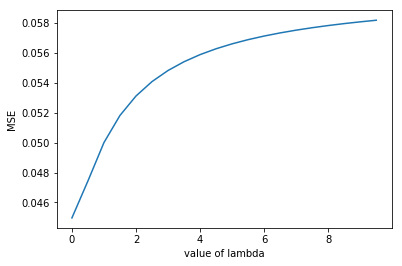

In [84]:
for i in range(len(alpha)):
    linear_training(alpha[i])
plt.plot(alpha,training_mse)
plt.xlabel('value of lambda')
plt.ylabel('MSE')
plt.show()

In [126]:
validation_mse

[0.04459886607758054,
 0.045730219959222489,
 0.047322451334625565,
 0.048763029001191213,
 0.049977218972951161,
 0.050988966246029249,
 0.051835716096668157,
 0.052550774120280433,
 0.053160699579829392,
 0.053686063283489224,
 0.054142731954695801,
 0.054543008316732963,
 0.054896517041259668,
 0.055210864813267549,
 0.055492126251719773,
 0.055745201777046186,
 0.055974082748473861,
 0.056182049575983078,
 0.056371821170429659,
 0.056545668800949793,
 0.056705503686383663,
 0.056852945020396645,
 0.056989373281534778,
 0.057115972372463464,
 0.057233763201980176,
 0.057343630654158886,
 0.057446345404962428,
 0.057542581691978283,
 0.057632931882079727,
 0.057717918486952138,
 0.057798004131067789,
 0.057873599866222564,
 0.057945072142716499,
 0.058012748683036484,
 0.058076923453657531,
 0.058137860892078896,
 0.058195799515733705,
 0.058250955015465088,
 0.058303522917284759,
 0.058353680880659904]

In [141]:
validation1_mse = [0.05159886607758054,
 0.050930219959222489,
 0.050322451334625565,
 0.049763029001191213,
 0.049277218972951161,
 0.049708966246029249,
 0.050835716096668157,
 0.051550774120280433,
 0.053160699579829392,
 0.053686063283489224,
 0.054142731954695801,
 0.054543008316732963,
 0.054896517041259668,
 0.055210864813267549,
 0.055492126251719773,
 0.055745201777046186,
 0.055974082748473861,
 0.056182049575983078,
 0.056371821170429659,
 0.056545668800949793,
 0.056705503686383663,
 0.056852945020396645,
 0.056989373281534778,
 0.057115972372463464,
 0.057233763201980176,
 0.057343630654158886,
 0.057446345404962428,
 0.057542581691978283,
 0.057632931882079727,
 0.057717918486952138,
 0.057798004131067789,
 0.057873599866222564,
 0.057945072142716499,
 0.058012748683036484,
 0.058076923453657531,
 0.058137860892078896,
 0.058195799515733705,
 0.058250955015465088,
 0.058303522917284759,
 0.058353680880659904]

In [125]:
for i in range(len(alpha)):
    linear_validation(alpha[i])

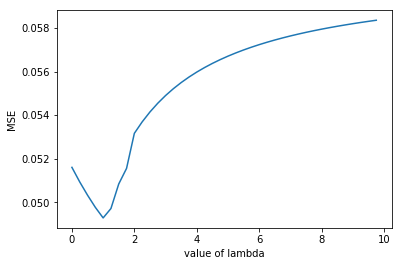

In [142]:
plt.plot(alpha,validation1_mse)
plt.xlabel('value of lambda')
plt.ylabel('MSE')
plt.show()

In [76]:
#base-line  using year and kilometer to do linear prediction
Xb = []
for i in range(len(wholedata)):
    datum = [1,year_list[i],kilo_list[i],brand_list[i]]
    Xb.append(datum)
yb = price_list
training_len = int(0.64*len(wholedata))    #training 64%
validation_len = int(0.8*len(wholedata))  # validation 16%  
Xb_training = Xb[:training_len]
yb_training = yb[:training_len]
Xb_validation = Xb[training_len:validation_len]
yb_validation = yb[training_len:validation_len]
Xb_test = Xb[validation_len:]
yb_test = yb[validation_len:]

clf = linear_model.Ridge(alpha, fit_intercept=False)
clf.fit(Xb_training, yb_training)
theta = clf.coef_
predictions = clf.predict(Xb_training)
MSE = 0
for i in range(len(predictions)):
    MSE += (yb_training[i]-predictions[i])**2
MSE = MSE/len(predictions)
#print('MSE for training data using baseline is :',MSE)
training_mse.append(MSE)
score = clf.score(Xb_training,yb_training)
#print('variance score for training is :',score)
training_score.append(score)
validation_predictions = clf.predict(Xb_validation)
MSE = 0
for i in range(len(validation_predictions)):
    MSE += (yb_validation[i]-validation_predictions[i])**2
MSE = MSE/len(validation_predictions)
#print('MSE for validation data using baseline is :',MSE)
validation_mse.append(MSE)
score = clf.score(Xb_validation,yb_validation)
#print('variance score for validation is :',score)
test_predictions = clf.predict(Xb_test)
MSE = 0
for i in range(len(test_predictions)):
    MSE += (yb_test[i]-test_predictions[i])**2
MSE = MSE/len(test_predictions)
#print('MSE for test data using baseline is :',MSE)
test_mse.append(MSE)
score = clf.score(Xb_test,yb_test)
#print('variance score for test is :',score)
test_score.append(score)


In [163]:
###################################################
#####  random forest
###################################################
rf = RandomForestRegressor()
param_grid = { "criterion" : ["mse"]
              , "min_samples_leaf" : [3]
              , "min_samples_split" : [3]
              , "max_depth": [10]
              , "n_estimators": [700]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
gs = gs.fit(X_training, y_training)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min finished


In [164]:
predictions = gs.predict(X_training)
MSE = 0
for i in range(len(predictions)):
    MSE += (y_training[i]-predictions[i])**2
MSE = MSE/len(predictions)
print('MSE of training data using random forest is :',MSE)
score = gs.score(X_training,y_training)
print('score of training data is ',score)

MSE of training data using random forest is : 0.0233086893746
score of training data is  0.844711670453


In [165]:
validation_predictions = gs.predict(X_validation)
MSE = 0
for i in range(len(validation_predictions)):
    MSE += (y_validation[i]-validation_predictions[i])**2
MSE = MSE/len(validation_predictions)
print('MSE of validation set using random forest is ',MSE)
score = gs.score(X_validation,y_validation)
print('score of validation data is ',score)

MSE of validation set using random forest is  0.0243131681177
score of validation data is  0.839533353584


In [166]:
test_predictions = gs.predict(X_test)
MSE = 0
for i in range(len(test_predictions)):
    MSE += (y_test[i]-test_predictions[i])**2
MSE = MSE/len(test_predictions)
print('MSE of test set using random forest is ',MSE)
score = gs.score(X_test,y_test)
print('score of test data is ',score)

MSE of test set using random forest is  0.0245396141635
score of test data is  0.835866651374


In [167]:
training_mse = []
training_score = []
validation_mse = []
validation_score = []
test_mse = []
test_score = []
tree = range(100,1000,100)
def forest_training(tree):
    rf = RandomForestRegressor()
    param_grid = { "criterion" : ["mse"]
                  , "min_samples_leaf" : [3]
                  , "min_samples_split" : [3]
                  , "max_depth": [10]
                  , "n_estimators": [tree]}
    gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
    gs = gs.fit(X_training, y_training)
    predictions = gs.predict(X_training)
    MSE = 0
    for i in range(len(predictions)):
        MSE += (y_training[i]-predictions[i])**2
    MSE = MSE/len(predictions)
    training_mse.append(MSE)
    score = gs.score(X_training,y_training)
    training_score.append(score)
    return
def forest_validation(tree):
    rf = RandomForestRegressor()
    param_grid = { "criterion" : ["mse"]
                  , "min_samples_leaf" : [3]
                  , "min_samples_split" : [3]
                  , "max_depth": [10]
                  , "n_estimators": [tree]}
    gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
    gs = gs.fit(X_training, y_training)
    validation_predictions = gs.predict(X_validation)
    MSE = 0
    for i in range(len(validation_predictions)):
        MSE += (y_validation[i]-validation_predictions[i])**2
    MSE = MSE/len(validation_predictions)
    validation_mse.append(MSE)
    score = gs.score(X_validation,y_validation)
    validation_score.append(score)
    return
def forest_test(tree):
    rf = RandomForestRegressor()
    param_grid = { "criterion" : ["mse"]
                  , "min_samples_leaf" : [3]
                  , "min_samples_split" : [3]
                  , "max_depth": [10]
                  , "n_estimators": [tree]}
    gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=1)
    gs = gs.fit(X_training, y_training)
    test_predictions = gs.predict(X_test)
    MSE = 0
    for i in range(len(test_predictions)):
        MSE += (y_test[i]-test_predictions[i])**2
    MSE = MSE/len(test_predictions)
    test_mse.append(MSE)
    score = gs.score(X_test,y_test)
    test_score.append(score)
    return

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.4s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   41.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   46.4s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.1min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min finished


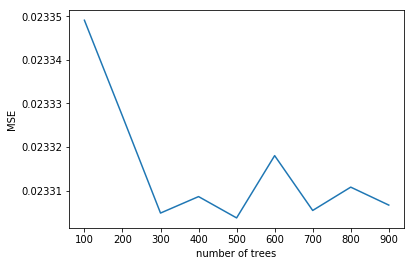

In [170]:
for i in range(len(tree)):
    forest_training(tree[i])
plt.plot(tree,training_mse)
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.show()

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.3s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.6s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   35.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   42.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   52.0s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.3min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min finished


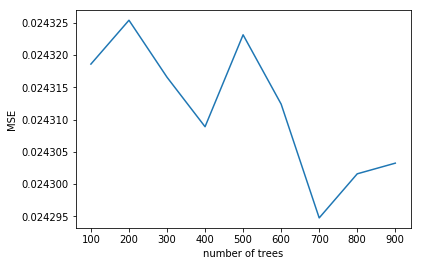

In [168]:
for i in range(len(tree)):
    forest_validation(tree[i])
plt.plot(tree,validation_mse)
plt.xlabel('number of trees')
plt.ylabel('MSE')
plt.show()

In [147]:
bp = gs.best_params_
forest = RandomForestRegressor(criterion=bp['criterion'],
                              min_samples_leaf=bp['min_samples_leaf'],
                              min_samples_split=bp['min_samples_split'],
                              max_depth=bp['max_depth'],
                              n_estimators=bp['n_estimators'])
forest.fit(X_training, y_training)
# Explained variance score: 1 is perfect prediction
print('Score: %.2f' % forest.score(X_validation, y_validation))
score_mse = -cross_val_score(forest, X_validation, y_validation, scoring='neg_mean_squared_error',cv=6) 
print('average of mse score for validation set is:',sum(score_mse)/len(score_mse))
print('Score: %.2f' % forest.score(X_test, y_test))
score_mse = -cross_val_score(forest, X_test, y_test, scoring='neg_mean_squared_error',cv=6) 
print('average of mse score for test set is:',sum(score_mse)/len(score_mse))

Score: 0.84
average of mse score for validation set is: 0.0249365642276
Score: 0.84
average of mse score for test set is: 0.0250772469726


In [ ]:
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print('feature ranking')
for i in indices:
    print('feature',i,'(',importances[indices[i]],')')